In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [3]:
df = pd.read_csv("./data/training_v2.csv")
keys = pd.read_csv("./data/WiDS_Datathon_2020_Dictionary.csv")

In [4]:
def bucket_plot(df, x_col, y_col, num_buckets=10, xlabel=None, ylabel=None, title="Bucket Scatter Plot"):
    df = df.copy()
    df["xcol"] = df.eval(x_col)
    df["ycol"] = df.eval(y_col)
    df = df[["xcol", "ycol"]].dropna()
    df["bucket"], edges = pd.cut(df["xcol"], bins=num_buckets, retbins=True, labels=False)
    
    bucket_stats = df.groupby("bucket").agg(
        mean_x=("xcol", "mean"),
        mean_y=("ycol", "mean")
    ).dropna()
    
    plt.scatter(bucket_stats["mean_x"], bucket_stats["mean_y"], color='b', edgecolors='black', alpha=0.7)
    
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.title(title)
    
    plt.show()

# Basic Visualizations

In [5]:
# list(df.columns)

<Axes: >

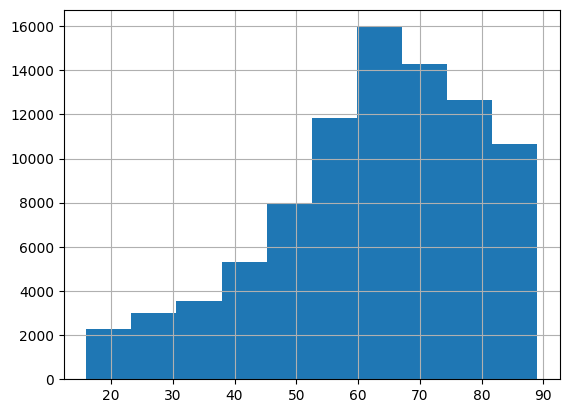

In [6]:
df.age.hist()

In [7]:
"Male percentage:", df.eval("gender == 'M'").mean()

('Male percentage:', 0.5393891814682761)

In [8]:
diseases = ['leukemia', 'hepatic_failure', 'immunosuppression', 'lymphoma', 'cirrhosis', 'aids']

results = {}
for disease in diseases:
    t_stat, p_val = ttest_ind(
        df.query("gender == 'M'")[disease], 
        df.query("gender == 'F'")[disease], 
        equal_var=False, 
        nan_policy='omit'
    )
    results[disease] = {'tstat M = F': t_stat}

pd.concat([
    df.groupby('gender')[diseases].mean(), 
    pd.DataFrame(results)
])

,leukemia,hepatic_failure,immunosuppression,lymphoma,cirrhosis,aids
F,0.005946,0.010698,0.026745,0.003868,0.012776,0.000406
M,0.008025,0.014950,0.025684,0.004359,0.018189,0.001242
tstat M = F,3.775242,5.719781,-0.997168,1.154392,6.638639,4.473519


In [9]:
df.groupby('ethnicity').encounter_id.count() / len(df)

ethnicity
African American    0.104096
Asian               0.012310
Caucasian           0.770709
Hispanic            0.041390
Native American     0.008592
Other/Unknown       0.047692
Name: encounter_id, dtype: float64

In [10]:
diseases = ['leukemia', 'hepatic_failure', 'immunosuppression', 'lymphoma', 'cirrhosis', 'aids']
df.groupby('ethnicity')[diseases].mean() 

,leukemia,hepatic_failure,immunosuppression,lymphoma,cirrhosis,aids
ethnicity,,,,,,
African American,0.006025,0.008139,0.023888,0.002220,0.008879,0.002960
Asian,0.005329,0.014210,0.024867,0.005329,0.015986,0.000000
Caucasian,0.007443,0.012661,0.027362,0.004591,0.015114,0.000570
Hispanic,0.007443,0.020734,0.021531,0.001861,0.025518,0.000797
Native American,0.006394,0.070332,0.025575,0.003836,0.081841,0.001279
Other/Unknown,0.004834,0.014733,0.021639,0.003453,0.023020,0.001381


## Findings: 
- Mean age is 62, left skewed. Younger people is underrepresented.
- Similar number of male and female
    - Men are likely to have disease.
    - The difference is significant in cirrhosis, hepatic failure, aids, and leukemia
        - Guess: cirrhosis because men drink more, aids because gays are categorized as men
- 77% of patients are white.
    - Caucasian vs Native American shows sign. difference
    - Caucasian vs African American shows notable difference.

# Modelling

## Try throwing data in

Now it depends what we are doing. I chose cirrhosis for now since it is the only one i have a good idea about. :)

In [11]:
labs = ["d1_bilirubin_max", "d1_bilirubin_min", "d1_albumin_max", "d1_albumin_min"]

ChatGPT said these are the things to look for. Seems true...
Note that below are mostly chat's work.

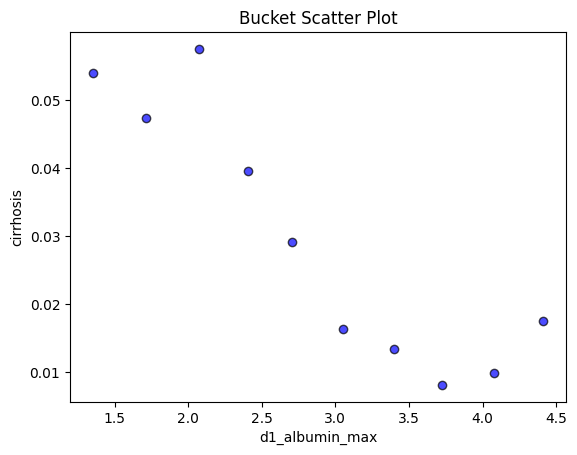

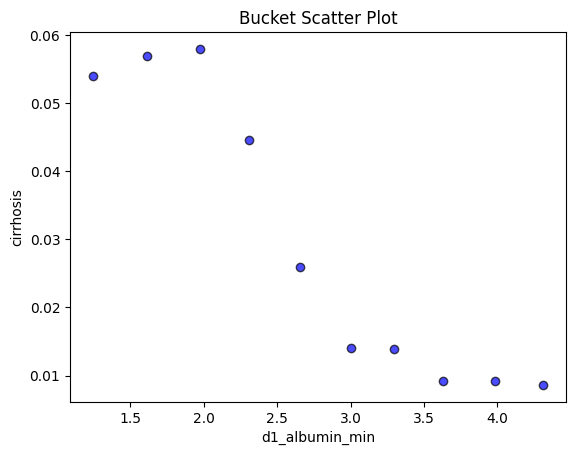

In [12]:
bucket_plot(df, "d1_albumin_max", "cirrhosis")
bucket_plot(df, "d1_albumin_min", "cirrhosis")

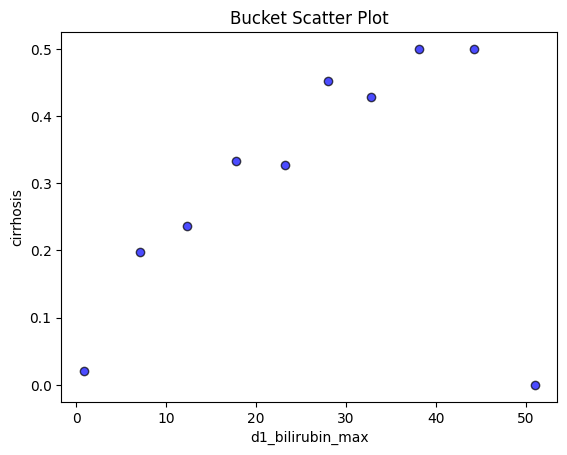

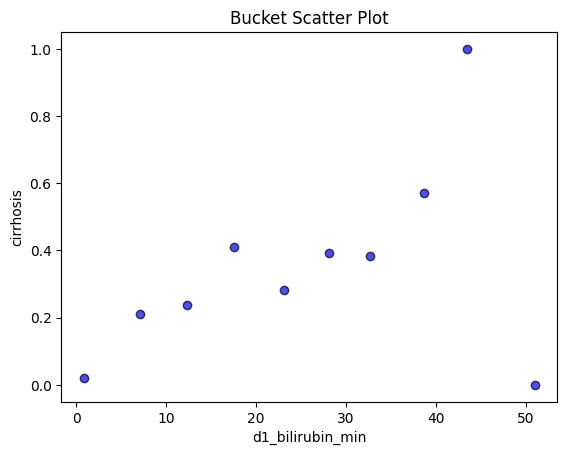

In [15]:
bucket_plot(df, "d1_bilirubin_max", "cirrhosis")
bucket_plot(df, "d1_bilirubin_min", "cirrhosis")

In [33]:
def train_model (df) :
    features = [
        'd1_albumin_max', 'd1_albumin_min',
        'd1_inr_max','d1_inr_min',
        'd1_bilirubin_max', 'd1_bilirubin_min',
        
        'd1_platelets_min',
        'map_apache', 'd1_mbp_min',
        'creatinine_apache', 'd1_creatinine_max',
        'urineoutput_apache', 
        'bun_apache',
        'd1_sodium_min', 'd1_potassium_max',
        'd1_temp_max', 'd1_temp_min',
        'd1_wbc_max', 'd1_wbc_min',
        'd1_lactate_max'
    ]
    
    groups = ["gender", "age", "ethnicity"]
    
    target = 'cirrhosis'
    df = df.dropna(subset=[target])
    
    X = df[features + groups]
    y = df[[target] + groups]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    model.fit(X_train[features], y_train[target])

    return model, (X_test, y_test)

In [34]:
def print_classification_report (model, validation_set, group = "index == index") : 
    X_test, y_test = validation_set
    y_pred = model.predict(X_test.query(group)[features])
    print("\nClassification Report:")
    print(classification_report(y_test.query(group)[target], y_pred))

In [97]:
def print_confusion_matrix (model, validation_set, group = "index == index") :
    X_test, y_test = validation_set
    y_pred = model.predict(X_test.query(group)[features])
    cm = confusion_matrix(y_test.query(group)[target], y_pred)
    n = len(y_test.query(group))

    print("Confusion Matrix (Proportions):")
    print(f"              Predicted 0     Predicted 1")
    print(f"Actual 0      {cm[0][0] / n * 100:.2f} %          {cm[0][1] / n * 100:.2f} %")
    print(f"Actual 1      {cm[1][0] / n * 100:.2f} %          {cm[1][1] / n * 100:.2f} %")

In [35]:
model, validation_set = train_model(df)

In [36]:
print_classification_report (model, validation_set)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     26836
         1.0       0.57      0.03      0.05       464

    accuracy                           0.98     27300
   macro avg       0.78      0.51      0.52     27300
weighted avg       0.98      0.98      0.98     27300



We have accuracy of 98%!!!

That comes with 57% precision, 3% recall. i.e. of all cases model say has cirrhosis, only 57% has, and out of all cirrhosis cases, the model found 3%. Not ideal. Let's see the report on each of the groups.

In [37]:
print_classification_report (model, validation_set, "gender == 'M'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     14487
         1.0       0.62      0.03      0.05       294

    accuracy                           0.98     14781
   macro avg       0.80      0.51      0.52     14781
weighted avg       0.97      0.98      0.97     14781



In [38]:
print_classification_report (model, validation_set, "gender == 'F'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12342
         1.0       0.50      0.02      0.04       170

    accuracy                           0.99     12512
   macro avg       0.74      0.51      0.52     12512
weighted avg       0.98      0.99      0.98     12512



The model performs worse on Female!

In [41]:
print_classification_report (model, validation_set, "ethnicity == 'Native American'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       222
         1.0       0.80      0.27      0.40        15

    accuracy                           0.95       237
   macro avg       0.88      0.63      0.69       237
weighted avg       0.94      0.95      0.94       237



In [42]:
warnings.filterwarnings('ignore')
print_classification_report (model, validation_set, "ethnicity == 'African American'") 


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2828
         1.0       0.00      0.00      0.00        27

    accuracy                           0.99      2855
   macro avg       0.50      0.50      0.50      2855
weighted avg       0.98      0.99      0.99      2855



In [43]:
print_classification_report (model, validation_set, "ethnicity == 'Caucasian'")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     20666
         1.0       0.50      0.02      0.04       348

    accuracy                           0.98     21014
   macro avg       0.74      0.51      0.52     21014
weighted avg       0.98      0.98      0.98     21014



The model simply says "no cirrhosis" to black patients!

All of this while the model did not actually know the ethnicity of the patient. The model only get the lab and vital data.

### Age
My Hypothesis: cirrhosis takes a few years to develop. People drinks in there 30-40 and get cirrhosis 50-60. If not, they are not drinkers, and wouldn't get it later in their life.

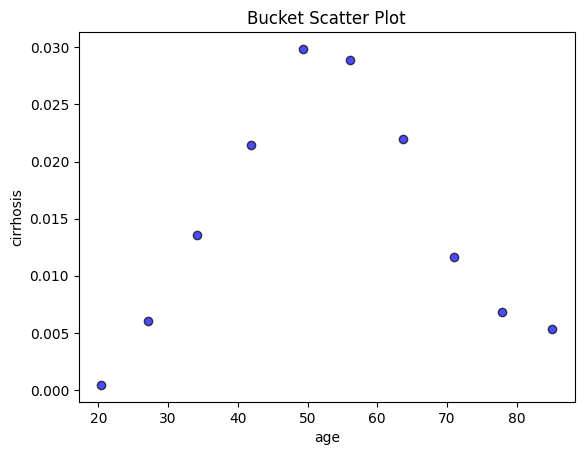

In [24]:
bucket_plot(df, "age", "cirrhosis")

## Fixing Precision and Recall
One problem with the last model where we just throw data in is that the model optimizes for accuracy, but we don't really want accuracy. Simply say no already gives us 97%. What we might want from this diagnosis model is recall and precision. Out of all patients with disease, we want model to say positive as many as possible (recall) but we also don't want the model to say yes all the time, so out of all that they say yes, we want a lot to be actually positive. (precision)

In [50]:
df_size = 3000

positive = df[df['cirrhosis'] == 1]
negative = df[df['cirrhosis'] == 0]

positive_sampled = positive.sample(n=df_size, replace=True, random_state=42)
negative_sampled = negative.sample(n=df_size, replace=False, random_state=42)

df_balanced = pd.concat([negative_sampled, positive_sampled], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [52]:
len(df), len(df_balanced)

(90998, 6000)

From the total 90k records, we rebalanced the dataframe to only include 6k with equal cases and non-cases of cirrhosis. Now, the model can't just say no, right?

In [53]:
model, validation_set = train_model(df_balanced)

In [54]:
print_classification_report (model, validation_set)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       913
         1.0       0.89      0.91      0.90       887

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



### Is it gender balanced? 

In [67]:
len(df_balanced.query("gender == 'M' and cirrhosis == 1")), len(df_balanced.query("gender == 'M'"))

(1936, 3588)

In [68]:
len(df_balanced.query("gender == 'F' and cirrhosis == 1")), len(df_balanced.query("gender == 'F'"))

(1064, 2412)

In [98]:
print_confusion_matrix (model, validation_set, "gender == 'M'")

Confusion Matrix (Proportions):
              Predicted 0     Predicted 1
Actual 0      40.55 %          5.84 %
Actual 1      5.02 %          48.58 %


In [99]:
print_confusion_matrix (model, validation_set, "gender == 'F'")

Confusion Matrix (Proportions):
              Predicted 0     Predicted 1
Actual 0      52.20 %          5.25 %
Actual 1      3.26 %          39.29 %


The model predicted false more often for women. It actually also wrong less often. This fits with the reality where women empirically don't have cirrhosis. Is this a good thing? 
- the model has high accuracy, precision, and recall
- it seems that it capture the reality well.
- what if the next patient is a heavy drinker women ? 

# What do we think about fake data?
- On one hand, we can create a dataset where there is a column `drinker`. We can then demonstrate that the model biased toward men being drinker, thus higher likelihood of cirrhosis.
- On the other hand, the data is fake. That is bad in itself (?)

I'm on the side supporting fake (but sensible) dataset where we only add the column drinker in this one. Then, we show that the fixed model still bias (not on saying no all the time) but on make being drinker. Then, we show yet another balanced dataset. 

Of course, this might just be enough already. Of course, other ideas are more than welcome!